In [5]:
# Assuming you have already installed prfpy_csenf

%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
opj = os.path.join
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from prfpy_csenf.model import CSenFModel
from prfpy_csenf.stimulus import CSenFStimulus
from prfpy_csenf.fit import CSenFFitter
from prfpy_csenf.rf import * 
from prfpy_csenf.csenf_plot_functions import *


import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive_output, VBox, HBox
from IPython.display import display


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load stimulus  

In [6]:
# Make some example experiment parameters.
sfs_seq = np.load('eg_sfs_seq.npy')
con_seq = np.load('eg_con_seq.npy')


In [7]:
# Following the prfpy structure, we can create a stimulus object
# This will put all the stimuli information in one place
# requires: 
# > the sequence of SFs presented (i.e., 1 per TR, blanks represented with 0) 
# > the sequence of contrasts presented ("")
# > TR
csenf_stim = CSenFStimulus(
    SF_seq  = sfs_seq, # np array, 1D 
    CON_seq = con_seq, # np array, 1D 
    TR      = 1.5,
    discrete_levels = True, # Set to false if levels of SFs and contrasts are not discrete 
    )

Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


# FULL WIDGET MULTI
Compare multiple different instances at the same time. Use comma to create different instances

TRY PUTTING ', 6' in the SFp box...


Output()

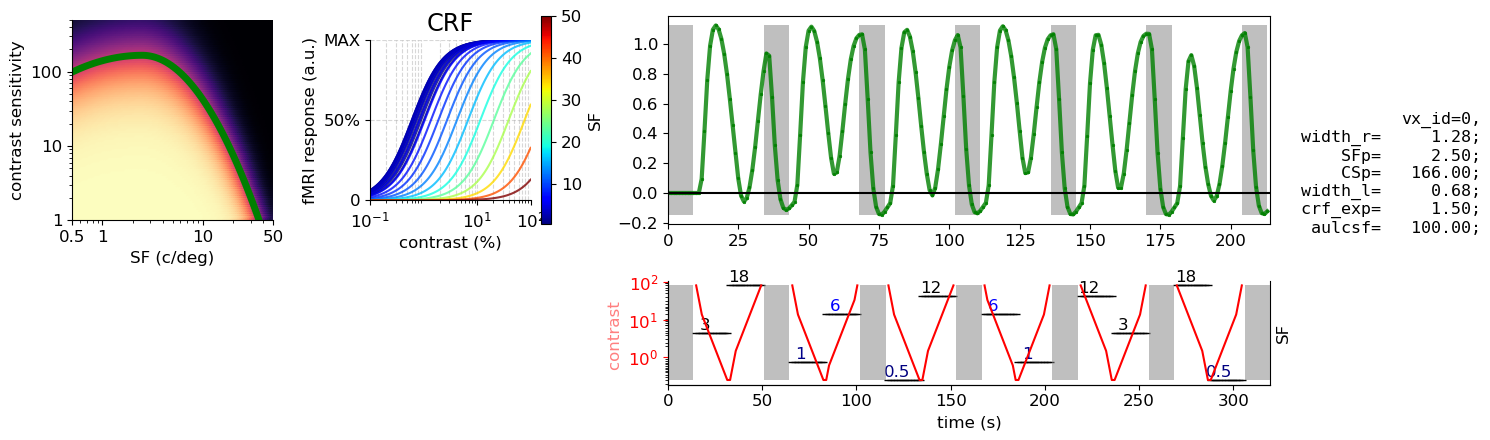

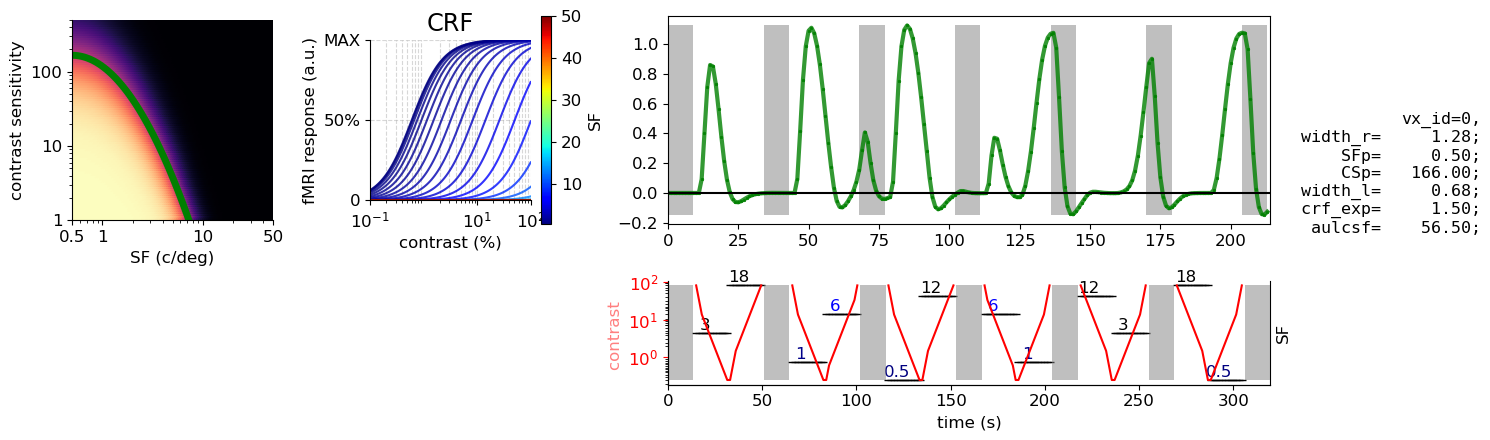

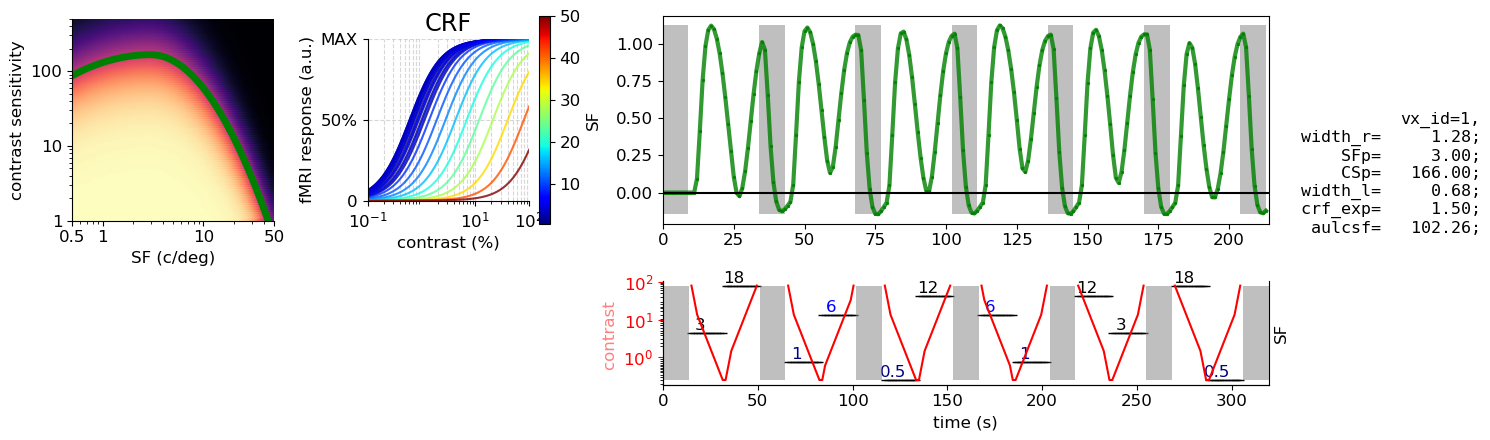

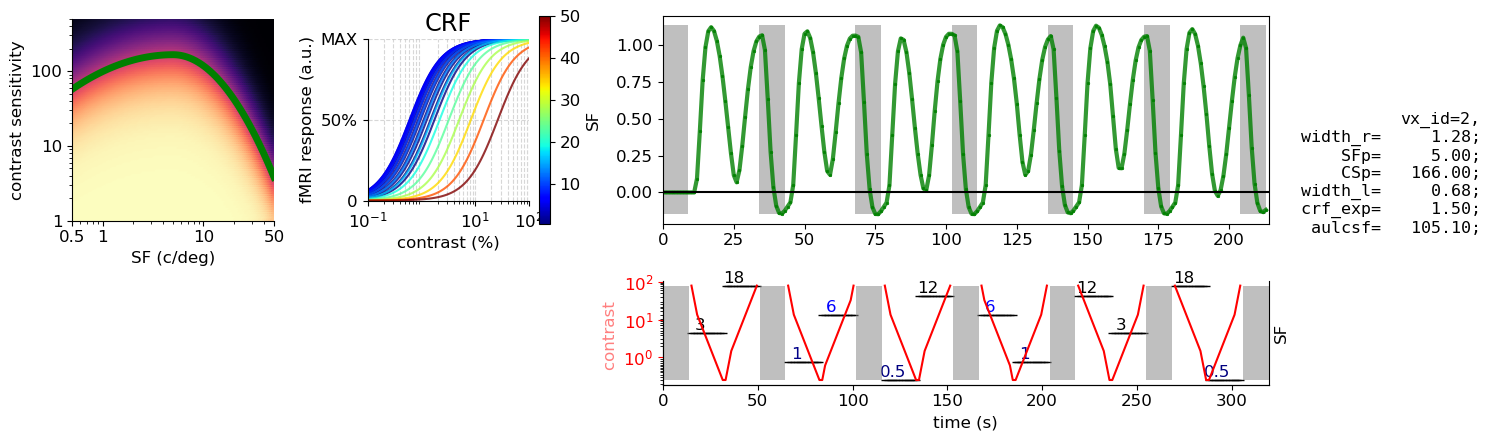

In [ ]:
# ***************** WIDGETS CSF MULTI *****************
# TRY PUTTING ', 6' in the SFp box...
# SEE IT MAKES MULTIPLE INSTANCES

default_kwargs = {
    'SF_list' : np.logspace(np.log10(0.5),np.log10(50), 25),
    'SF_cmap' : 'jet',
}
# Make a widget with editable parameters for 1 model only
# For the first entry CSF parameters are taken from the Chung & Legge paper. 
# Everything else is picked pretty randomly
w_params = {
    'width_r'   : 1.28,
    'SFp'       : 2.50,
    'CSp'      : 166.0,
    'width_l'   : 0.68,
    'crf_exp'   : 1.5,
    'amp_1'      : 1.0,
    'bold_baseline'  : 0.0,
    'hrf_1'     : 1.0,
    'hrf_2'     : 0.0,
    'edge_type' : 'CRF',
    }
w_params_keys = list(w_params.keys())


widg_controls=[]
for key in w_params_keys[:-1]:    
    sl=widgets.Text(
        description=key,
        value=f'{w_params[key]:<8.2f},',
        orientation = "vertical",
        continuous_update=False,
        font_family='monospace',
        )
    widg_controls.append(sl)
widg_controls.append(
    widgets.Text(
        description='edge_type',
        value=f'{w_params["edge_type"]:<8},',
        orientation="vertical",
        continuous_update=False,
        font_family='monospace',
    )
)

widg_Dict = {} 
for c in widg_controls:
    widg_Dict[c.description] = c  

left_widg = widgets.VBox(tuple([widg_controls[i] for i in range(5)]))
right_widg = widgets.VBox([widg_controls[i] for i in range(5,10)])
widg_uif = widgets.HBox([left_widg, right_widg])

def widg_output_to_dict(widg_output):
    # [1] Find number of plots 
    param_dict = {}
    n_plots = {}
    for i,p in enumerate(w_params_keys[:-1]):
        # Split widg_output[i] by ',' returning list (not including ',' itself)
        param_vals = widg_output[i].split(',')
        # remove any entry which does not contain a number in the string
        param_vals = [s for s in param_vals if any(c.isdigit() for c in s)]
        # Convert to float
        param_vals = [float(s) for s in param_vals]
        n_plots[p] = len(param_vals)
        param_dict[p] = param_vals
    # Now deal with CRF vs BINARY
    p = 'edge_type'
    i = -1

    param_dict[p] = widg_output[i].split(',')
    param_dict[p] = [i for i in param_dict[p] if i!='']
    n_plots[p] = len(param_dict[p])
    max_n_plots = np.max(list(n_plots.values()))
    # Loop through each parameter, and if it has less than max_n_models, duplicate the last value
    # until it has max_n_plot
    for i,p in enumerate(w_params_keys):
        while n_plots[p] < max_n_plots:
            # Duplicate the last value
            param_dict[p] = np.append(param_dict[p], param_dict[p][-1])
            n_plots[p] = len(param_dict[p])
    
    # Now make a list of dictionaries with 1 entry
    dict_list = []
    for i in range(max_n_plots):
        this_dict = {}
        for p in w_params_keys:
            this_dict[p] = param_dict[p][i]
        dict_list.append(this_dict)
    # We return both forms...
    return param_dict, dict_list

class Widg_Updater():
    def __init__(self):
        self.do_update = True


    def widg_update_N(self, **xvalor):
        if not self.do_update: # make sure we don't loop around and around...
            return
        self.do_update = False
        try:
            # *** 
            xvalor=[]
            for i,p in enumerate(w_params_keys):
                xvalor.append(widg_controls[i].value)
            param_dict,dict_list = widg_output_to_dict(xvalor)
            # Before 
            # Use this to update the widget values
            for i,p in enumerate(w_params_keys[:-1]):
                # widg_str is a string of comma separated values, equally spaced, with 2 decimal points 
                widg_str = ','.join([f'{v:<8.2f}' for v in param_dict[p]])
                widg_controls[i].value = widg_str
            p = 'edge_type'
            i = -1        
            widg_str = ','.join([f'{v:<8}' for v in param_dict[p]])        
            widg_controls[i].value = widg_str
            edge_list = widg_controls[-1].value.split(',')
            # remove spaces and empty strings
            edge_list = [i.strip() for i in edge_list if i!='']

            this_plotter = {}
            for edge_type in edge_list:
                this_model = CSenFModel(csenf_stim, edge_type=edge_type)
                print(f'edge_type: {edge_type}')
                this_plotter[edge_type] = CSenFPlotter(param_dict, prfpy_model=this_model, **default_kwargs)
            # Do the plotting!
            for i in range(len(dict_list)):
                this_edge_type = param_dict['edge_type'][i].strip()
                _ = this_plotter[this_edge_type].csf_ts_plot(i, **default_kwargs)
        except Exception as e:
            print(f'Error: {e}')
        

        self.do_update = True
        return

w_update = Widg_Updater()

widg_outf = widgets.interactive_output(w_update.widg_update_N,widg_Dict)
display(widg_uif, widg_outf)